In [35]:
import math  
import numpy as np   
import random  as rd
import matplotlib.pyplot as plt  
from matplotlib import colors
import numba  
from numba import njit  
import time  
from matplotlib.pyplot import figure
import random as rd

In [36]:
from scipy.sparse import csr_matrix
from scipy import linalg

In [37]:
# from scipy import misc

# np.random.seed(0)
# plt.close('all')

# # Load image
# X = misc.ascent()
# X = X/np.max(X)
# ny, nx = X.shape
# plt.imshow(X,cmap="gray")

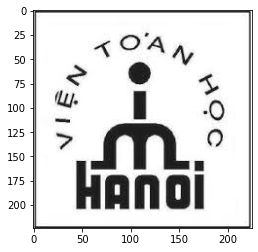

In [38]:
import cv2
import matplotlib.pyplot as plt
img=cv2.imread("vast.jpg",0)

#Displaying image using plt.imshow() method
plt.imshow(img,cmap="gray")

In [39]:
img.shape

(224, 225)

In [40]:
rank = np.linalg.matrix_rank(img)
rank

210

In [41]:
n1,n2 = img.shape
min_dim = min(n1,n2)
min_dim

224

In [42]:
U, s, VT = np.linalg.svd(img, full_matrices=True )

In [43]:
# r = rank(A_masked)

s[min_dim-100:] = 0

S = np.zeros((n1, n2))

S[:min_dim, :min_dim] = np.diag(s)
img_downrank = U@(S@VT)

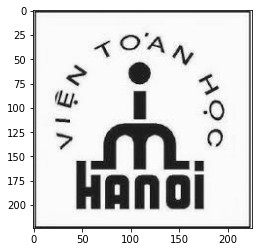

In [44]:
plt.imshow(img_downrank,cmap="gray")

In [45]:
M = img
n1,n2 = M.shape
ratio = 0.2
p = round(n1*n2*ratio)

In [46]:
# n1=200
# n2=200
# r=4
# ratio = 0.3
# def  create_fake_data():
#     K= np.random.rand(n1, r)
#     L= np.random.rand(r, n2)
#     return K@L
# M = create_fake_data()


Omega  =  [ ]
# p = round(n1*n2*ratio)
# p = 96000    

def get_m_random_index_of_matrix(n_1, n_2, m):
    return rd.sample([(i, j) for i in range(n_1) for j in range(n_2)], m)
Omega = np.array(get_m_random_index_of_matrix(n1, n2, p))

b = np.empty( (p), np.float_)
for i in range(p):
    b[i] = M[Omega[i,0], Omega[i,1]]


In [47]:
# A= csr_matrix( (n1*n2, p), np.float_)
index = [ o[0]*n2+ o[1] for o in Omega]
index
A= csr_matrix(([1]*p, (range(p),index)), shape=(p, n1*n2)  )
A_T=  A.T

In [48]:
AA_T =A@A_T
A_TA =A_T@A
A_Tb  =  A_T@b

In [49]:
mu_0 = np.linalg.norm((A.T) * b)*(1e-4)

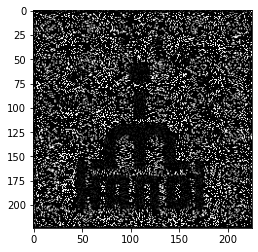

In [50]:
#image sau khi lấy nhiễu
X0= np.zeros((n1,n2))
for id in range(len( Omega)):
    i,j = Omega[id]
    X0[i,j] = b[id]
# X = matrix(X0)
plt.imshow(X0,cmap="gray")

In [51]:
rank = np.linalg.matrix_rank(X0)
rank

224

In [52]:
z=np.random.rand ( (n1*n2))


In [53]:
z

array([0.97286445, 0.93077261, 0.32221715, ..., 0.55166601, 0.40199156,
       0.83249844])

In [54]:
beta =1
mu = 1

In [55]:
def vec_to_mat_X(X):
    return np.reshape(X, (n1, n2))
# def vec_to_mat_X(X):
    # return np.reshape(X, (n1, n2))
# vec_to_mat_X(X).flatten()-X



In [56]:
mu_0 = np.linalg.norm((A.T) * b)*(1e-4)

$\nabla f_2(X)  = A^T*A*X - A^T*b$

In [57]:

def nablaf_2(z):
    return A_TA@z- A_Tb
def compute_y_n( z, beta):
    return z-(1/beta)*nablaf_2(z)
nablaf_2(z)

array([0., 0., 0., ..., 0., 0., 0.])

Ta can giải bài toán $min   \frac{1}{2}|AX-b|^2_2 +u*|X|_*$

where $A\in Mat_{p, n1*n2}$, and $X\in R^{n1*n2}$

*step 1: $y_n = z_n - \beta*∇f_2(z_n)$

where 

$z_n =X$

$$Prox_{1/\beta f_1} (y) =  U.p(\lambda).V^T$$

where $$p(\lambda) =  pos(\lambda-\beta)$$

$$\tau = \mu /  \beta$$

In [ ]:
mu_0 = np.linalg.norm((A.T) * b)*(1e-4)

In [58]:

def proximal_nuclear(Y, beta, mu):
    tau = (mu/beta)
    U,Sigma,V = linalg.svd(np.reshape(Y, (n1, n2)))
    full_sigma  = np.zeros( (n1,n2), np.float_)
    for i in range(len(Sigma)):
        if Sigma[i]>tau:
            full_sigma[i][i] = Sigma[i]-tau
    return (U@full_sigma)@V
# proximal_nuclear(yticks, beta, mu )

In [59]:
def compute_x(z, mu=1, beta=1):
    y = compute_y_n( z, beta=1)
    return proximal_nuclear(y , beta, mu).flatten()


In [60]:
compute_x(z)

array([0.97391345, 0.94052025, 0.34128582, ..., 0.42651834, 0.51012694,
       0.86639648])

In [61]:
def main_loop(z, beta=1, mu=1, loop_size=1000 ):
    t=np.zeros( (loop_size), np.float_)
    t[0]=1
    Z=z
    Xold = compute_x(Z)
    # print(Xold.shape)
    # z=np.zeros( (loop_size), np.float_)
    frobenius_norm_ratio_old = 1
    for n in range(loop_size-1):

        t[n+1]= (math.sqrt(4*t[n]*t[n]+1)+1)/2
        lambda_loop = 1+ (t[n]-1)/t[n+1]


        X = compute_x(Z)

        Z= Xold+ lambda_loop*(X-Xold)
        # print(Z)

        # print(Z)
        Xold = X

        # print(n, np.linalg.norm(vec_to_mat_X(Z)-M)/ np.linalg.norm(M))
        frobenius_norm_ratio = ( np.linalg.norm(vec_to_mat_X(Z)-M, "fro") / np.linalg.norm(M, "fro"))
        if frobenius_norm_ratio_old- frobenius_norm_ratio<0.00000001:
            break
        else: 
            frobenius_norm_ratio_old  = frobenius_norm_ratio
        # if frobenius_norm_ratio < 0.01:
        print(n, frobenius_norm_ratio)
            # break
    return Z


In [62]:
X1=X0.flatten()
X1.shape

(50400,)

In [63]:
image_new = main_loop(X1, beta=1, mu=mu_0, loop_size=1000)


0 0.8943102272115933
1 0.8942016795786161
2 0.8940699299839138
3 0.8939153809208894
4 0.8937383218082864
5 0.8935389783326632
6 0.8933175378692335
7 0.8930742008056428
8 0.8928091125371798
9 0.8925223570315459
10 0.8922140626690719
11 0.8918843531290586
12 0.8915333679508144
13 0.8911611896022924
14 0.8907679341505313
15 0.8903537468317585
16 0.889918725788172
17 0.8894629437859699
18 0.8889865112558556
19 0.8884895416563493
20 0.8879720023134677
21 0.8874341705271125
22 0.8868761537904764
23 0.8862980343000589
24 0.8857000287030142
25 0.8850821486188429
26 0.8844445093083799
27 0.8837872565448699
28 0.8831103506178807
29 0.8824138444800653
30 0.8816979659532239
31 0.8809627490959674
32 0.8802083581249771
33 0.8794349259077788
34 0.8786425713933266
35 0.8778315060551055
36 0.8770020122793574
37 0.876154161514664
38 0.8752881222423916
39 0.8744039933068132
40 0.8735018928853062
41 0.8725818088352361
42 0.8716438413691538
43 0.8706882540144049
44 0.8697149349388082
45 0.8687241165491321


363 0.18471115515108827
364 0.18388107919254493
365 0.18307211464005801
366 0.18228382917504474
367 0.18151578414595365
368 0.18076751250418602
369 0.1800385147271043
370 0.17932826377072272
371 0.17863618606137785
372 0.17796169700518244
373 0.17730428973660192
374 0.17666355484685414
375 0.176039098132936
376 0.17543049242665879
377 0.17483728448484767
378 0.17425900970051508
379 0.1736952062010495
380 0.1731454228698925
381 0.17260922024810185
382 0.1720861959502965
383 0.1715759275459513
384 0.17107789888838065
385 0.17059159892839196
386 0.17011652458062212
387 0.16965216834824148
388 0.16919809036306233
389 0.16875389917611494
390 0.16831923733843057
391 0.16789378924701656
392 0.16747722165981865
393 0.1670691340480867
394 0.16666917225880196
395 0.16627706951348992
396 0.16589259225253977
397 0.16551552019135476
398 0.16514560851879595
399 0.16478257460426657
400 0.16442610705026356
401 0.16407591727135726
402 0.16373172443018807
403 0.16339329116072157
404 0.1630604681368646
4

In [64]:
frobenius_norm_ratio = ( np.linalg.norm(vec_to_mat_X(image_new)-img, "fro") / np.linalg.norm(M, "fro"))
frobenius_norm_ratio  

0.14871274620551989

In [65]:
rank = np.linalg.matrix_rank(image_new)
rank

1

Text(0.5, 1.0, '')

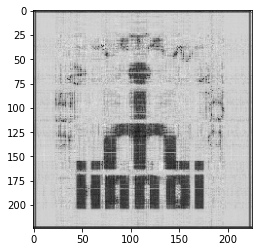

In [66]:
# plt.imshow(image_new.reshape(n1,n2),cmap="gray")
plt.imshow(image_new.reshape(n1,n2),cmap = "gray")
plt.title("")

Text(0.5, 1.0, 'Ảnh sau khi được phục hồi')

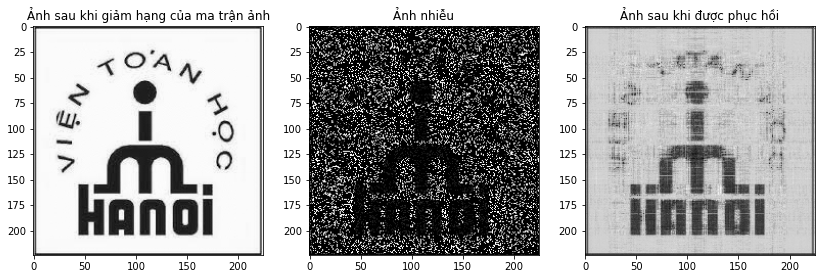

In [67]:
fig, (ax0,ax1, ax2) = plt.subplots(1, 3, figsize=(14,6))
# fig.suptitle('Horizontally stacked subplots')
ax0.imshow(img_downrank,cmap="gray")
ax0.set_title("Ảnh sau khi giảm hạng của ma trận ảnh")
ax1.imshow(X0,cmap="gray")
ax1.set_title("Ảnh nhiễu")
ax2.imshow(image_new.reshape(n1,n2),cmap = "gray")
ax2.set_title("Ảnh sau khi được phục hồi")

In [68]:
img.shape

(224, 225)

          $$ proximal_nuclear(X,beta,mu) =  prox_{\mu/beta}|| .||*  (X)$$